In [1]:
import holoviews as hv
import numpy as np
import pandas as pd
import panel as pn
import xarray as xr
from scipy.ndimage import gaussian_filter1d  # For smoothing position
from scipy.stats import multivariate_normal  # For creating posterior peaks

# --- Configuration ---
n_time = 10_000  # Number of time steps
sampling_frequency = 250  # Hz
n_xbins = 50  # Number of spatial bins in x
n_ybins = 50  # Number of spatial bins in y
x_range = (0, 100)  # Range of x dimension (e.g., cm)
y_range = (0, 100)  # Range of y dimension (e.g., cm)
smoothing_sigma = 5  # Smoothing factor for random walk
non_local_event_rate = 0.05  # Probability of a non-local posterior peak

# --- Generate Coordinates ---
time_coords = np.arange(n_time) / sampling_frequency
x_coords = np.linspace(x_range[0], x_range[1], n_xbins)
y_coords = np.linspace(y_range[0], y_range[1], n_ybins)
x_bin_centers = (x_coords[:-1] + x_coords[1:]) / 2
y_bin_centers = (y_coords[:-1] + y_coords[1:]) / 2
# Adjust if using bin centers vs edges - let's assume posterior uses centers
x_coords_posterior = x_bin_centers
y_coords_posterior = y_bin_centers
n_xbins_posterior = len(x_coords_posterior)
n_ybins_posterior = len(y_coords_posterior)


# --- Generate position_info (Pandas DataFrame) ---
# Simulate a smoothed random walk for position
x_pos = np.cumsum(np.random.randn(n_time))
y_pos = np.cumsum(np.random.randn(n_time))
x_pos = gaussian_filter1d(x_pos, sigma=smoothing_sigma)
y_pos = gaussian_filter1d(y_pos, sigma=smoothing_sigma)

# Scale to the desired range
x_pos = np.interp(x_pos, (x_pos.min(), x_pos.max()), x_range)
y_pos = np.interp(y_pos, (y_pos.min(), y_pos.max()), y_range)

# Calculate speed (simple difference)
dx = np.diff(x_pos, prepend=x_pos[0])
dy = np.diff(y_pos, prepend=y_pos[0])
speed = np.sqrt(dx**2 + dy**2) * sampling_frequency  # cm/s
speed = gaussian_filter1d(speed, sigma=smoothing_sigma / 2)  # Smooth speed slightly

# Simulate head direction (random, smoothed)
head_direction_raw = np.cumsum(np.random.randn(n_time) * 0.1)  # Slow drift
head_direction = np.mod(
    gaussian_filter1d(head_direction_raw, sigma=smoothing_sigma), 2 * np.pi
)

# Create DataFrame
position_info_df = pd.DataFrame(
    {
        "x": x_pos,
        "y": y_pos,
        "speed": speed,
        "head_direction": head_direction,
        "time": time_coords,
    }
).set_index("time")

# --- Generate posterior (xarray DataArray) ---
# Shape: (n_time, n_xbins_posterior, n_ybins_posterior)
posterior_data = np.zeros(
    (n_time, n_xbins_posterior, n_ybins_posterior), dtype=np.float32
)

# Create meshgrid for Gaussian calculation
X, Y = np.meshgrid(x_coords_posterior, y_coords_posterior)
pos_xy = np.dstack((X, Y))

# Simulate posterior peaks (mostly centered on true position, sometimes elsewhere)
for t in range(n_time):
    true_pos = position_info_df.iloc[t][["x", "y"]].values

    # Decide if this is a non-local event
    if np.random.rand() < non_local_event_rate:
        # Pick a random location for the peak
        center_pos = np.array(
            [np.random.uniform(*x_range), np.random.uniform(*y_range)]
        )
        cov_scale = 150  # Wider spread for non-local
    else:
        # Center peak near the true position with some noise
        center_pos = true_pos + np.random.randn(2) * 5  # Add decoding noise
        cov_scale = 50  # Tighter spread for local

    # Ensure center is within bounds
    center_pos[0] = np.clip(center_pos[0], *x_range)
    center_pos[1] = np.clip(center_pos[1], *y_range)

    # Create a 2D Gaussian distribution
    covariance = [[cov_scale, 0], [0, cov_scale]]
    try:
        rv = multivariate_normal(mean=center_pos, cov=covariance)
        prob_slice = rv.pdf(pos_xy)
    except (
        np.linalg.LinAlgError
    ):  # Handle potential singular covariance if cov_scale is tiny
        print(f"Warning: LinAlgError at time {t}, using uniform noise.")
        prob_slice = np.random.rand(n_xbins_posterior, n_ybins_posterior)  # Fallback

    # Add a small amount of uniform noise to avoid zero probabilities everywhere
    prob_slice += np.random.uniform(0, prob_slice.max() * 0.01, size=prob_slice.shape)

    # Normalize the slice so probabilities sum to 1
    prob_slice_sum = prob_slice.sum()
    if prob_slice_sum > 1e-9:  # Avoid division by zero
        posterior_data[t, :, :] = prob_slice / prob_slice_sum
    else:
        # If sum is tiny (e.g. due to LinAlgError fallback), use uniform
        posterior_data[t, :, :] = np.ones_like(prob_slice) / prob_slice.size


# Create xarray DataArray
posterior_xr = xr.DataArray(
    posterior_data,
    coords={
        "time": time_coords,
        "x_position": x_coords_posterior,
        "y_position": y_coords_posterior,
    },
    dims=["time", "y_position", "x_position"],  # Note y/x order convention might differ
    name="acausal_posterior",
).transpose(
    "time", "x_position", "y_position"
)  # Ensure desired final order


# --- Generate multiunit_firing_rate (xarray DataArray) ---
# Simulate some baseline firing with bursts correlated loosely with speed
base_rate = 15
speed_effect = 0.1
burst_rate = 50
burst_prob = 0.02

mua_rate = (
    base_rate + position_info_df["speed"] * speed_effect + np.random.randn(n_time) * 5
)  # Base rate + speed modulation + noise
bursts = np.random.rand(n_time) < burst_prob
mua_rate[bursts] += burst_rate * (
    0.5 + np.random.rand(bursts.sum())
)  # Add burst magnitude
mua_rate = np.maximum(0, mua_rate)  # Ensure non-negative

multiunit_firing_rate_xr = xr.DataArray(
    mua_rate, coords={"time": time_coords}, dims=["time"], name="multiunit_firing_rate"
)

# --- Generate non_local_prob (xarray DataArray) ---
# Simulate probability - higher during periods matching non-local posterior events
# (This is a simplification, real non-local prob would be derived from model)
non_local_prob_data = np.zeros(n_time)
# Make it higher when we generated a non-local event in the posterior
non_local_indices = np.where(np.random.rand(n_time) < non_local_event_rate)[0]
for idx in non_local_indices:
    # Simulate a rise and fall around the event time
    start = max(0, idx - int(0.1 * sampling_frequency))  # 100ms before
    end = min(n_time, idx + int(0.1 * sampling_frequency))  # 100ms after
    peak_prob = 0.6 + np.random.rand() * 0.4  # Random peak height (0.6 to 1.0)
    # Simple triangular pulse shape
    pulse = (
        np.concatenate(
            (
                np.linspace(0, peak_prob, idx - start + 1),
                np.linspace(peak_prob, 0, end - idx)[:-1],  # Avoid double counting peak
            )
        )
        if (end - start) > 0
        else np.array([peak_prob])
    )

    non_local_prob_data[start:end] = np.maximum(
        non_local_prob_data[start:end], pulse[: end - start]
    )  # Use max to overlap pulses


# Add some small background noise
non_local_prob_data += np.random.rand(n_time) * 0.05
non_local_prob_data = np.clip(non_local_prob_data, 0, 1)  # Ensure bounds 0 to 1

non_local_prob_xr = xr.DataArray(
    non_local_prob_data,
    coords={"time": time_coords},
    dims=["time"],
    name="non_local_probability",
)

# --- MAP Estimate ---
# Let the function calculate it by default, so set map_estimate = None
# If you need to test providing it, calculate it here:
# map_estimate_df = maximum_a_posteriori_estimate(posterior_xr)
map_estimate_input = None  # Let create_visualization calculate it


In [31]:

import numpy as np
import pandas as pd
import xarray as xr
from holoviews import opts
from holoviews.operation.datashader import rasterize

from non_local_detector.analysis.posterior import maximum_a_posteriori_estimate


def create_2D_decoding_plot(
    position_info: pd.DataFrame,
    posterior: xr.DataArray,
    map_estimate=None,
    sampling_frequency=250,
    width=800,
    height=600,
    head_dir_radius=4,
    position_names=("x", "y"),
    head_dir_name="head_direction",
    cmap="viridis",
    animal_color="magenta",
    decode_opacity=1.0,
    target_fps=30,  # Added target_fps parameter
):
    n_time = len(posterior.time)

    if map_estimate is None:
        print("Calculating MAP estimate for plot...")
        map_estimate = maximum_a_posteriori_estimate(posterior)
        print("MAP estimate calculated.")

    prob_min = 0.0
    prob_max = float(posterior.quantile(0.995))
    if prob_max <= prob_min:
        prob_max = float(posterior.max())
    if prob_max <= prob_min:
        prob_max = 1.0
    color_limits = (prob_min, prob_max)
    print(f"Using color limits for posterior: {color_limits}")

    def get_animal_position_dot(time_ind):
        time_ind = max(0, min(time_ind, len(position_info) - 1))
        pos_slice = position_info.iloc[[time_ind]]
        head_point = hv.Scatter(
            pos_slice, kdims=position_names[0], vdims=position_names[1]
        ).opts(size=10, color=animal_color)
        x_start, y_start = (
            pos_slice.iloc[0][position_names[0]],
            pos_slice.iloc[0][position_names[1]],
        )
        direction = pos_slice.iloc[0][head_dir_name]
        x_end, y_end = x_start + head_dir_radius * np.cos(
            direction
        ), y_start + head_dir_radius * np.sin(direction)
        head_direction_line = hv.Segments(
            [{"x0": x_start, "y0": y_start, "x1": x_end, "y1": y_end}]
        ).opts(color=animal_color, line_width=3)
        return (head_point * head_direction_line).opts(width=width, height=height)

    # --- Use hv.Image ---
    def get_posterior_image(time_ind):
        time_ind = max(0, min(time_ind, n_time - 1))
        posterior_slice = posterior.isel(time=time_ind)
        # hv.Image often expects data ordered (y, x) dimensions
        # Ensure your posterior_slice matches this convention.
        # Check dims: posterior_slice.dims -> should be ('y_position', 'x_position') or similar
        # If needed, transpose: img_data = posterior_slice.transpose('y_position', 'x_position')
        # Assuming the data passed is already (y, x) based on previous code structure
        img_data = posterior_slice  # If dims are ('y_position', 'x_position')

        return hv.Image(
            img_data,  # Pass the 2D DataArray slice
            kdims=["x_position", "y_position"],  # Match dimensions in data
            vdims=["probability"],
            label="Posterior Prob (Image)",
        ).opts(
            cmap=cmap,
            alpha=decode_opacity,
            width=width,
            height=height,
            clim=color_limits,  # Apply consistent color limits
            bgcolor=None,
            colorbar=True,
            clabel="Probability",
        )

    # --- End hv.Image ---

    def get_most_likely_decoded_position(time_ind):
        time_ind = max(0, min(time_ind, len(map_estimate) - 1))
        map_slice = map_estimate[[time_ind]]
        return hv.Scatter(map_slice, kdims="x_position", vdims="y_position").opts(
            color="green", size=10, width=width, height=height
        )

    # --- Create Player Controls (using target_fps) ---
    player = create_player(
        n_time,
        sampling_frequency=sampling_frequency,
        width=int(width * 0.7),
    )
    playback_speed_dropdown = create_playback_speed_dropdown(
        player, width=int(width * 0.2)
    )

    # --- Create Dynamic Elements ---
    animal_position_dot = hv.DynamicMap(
        pn.bind(get_animal_position_dot, player.param.value)
    )

    # --- Use hv.Image DynamicMap (NO rasterize needed) ---
    posterior_plot = hv.DynamicMap(pn.bind(get_posterior_image, player.param.value))
    # ---

    most_likely_decoded_position_dot = hv.DynamicMap(
        pn.bind(get_most_likely_decoded_position, player.param.value)
    )

    # --- Combine Elements ---
    overlay_plot = (
        posterior_plot * most_likely_decoded_position_dot * animal_position_dot
    )

    # Layout
    decode_plot_layout = pn.Column(
        overlay_plot, pn.Row(player, playback_speed_dropdown)
    )
    return decode_plot_layout, player


def create_2D_decoding_plot_optimized(  # Renamed for clarity
    position_info: pd.DataFrame,
    posterior: xr.DataArray,
    map_estimate=None,
    sampling_frequency=250,
    width=800,
    height=600,
    head_dir_radius=4,
    position_names=("x", "y"),
    head_dir_name="head_direction",
    cmap="viridis",
    animal_color="magenta",
    decode_opacity=1.0,
    target_fps=30,  # Note: target_fps is used indirectly via player interval
):
    n_time = len(posterior.time)

    if map_estimate is None:
        print("Calculating MAP estimate for plot...")
        map_estimate = maximum_a_posteriori_estimate(posterior)
        print("MAP estimate calculated.")

    prob_min = 0.0
    prob_max = float(posterior.quantile(0.995))
    if prob_max <= prob_min:
        prob_max = float(posterior.max())
    if prob_max <= prob_min:
        prob_max = 1.0
    color_limits = (prob_min, prob_max)
    print(f"Using color limits for posterior: {color_limits}")

    # --- Pre-compute Posterior Images into a HoloMap ---
    print("Pre-computing posterior images for HoloMap...")
    posterior_images = {}
    # Ensure posterior is loaded into memory if it's chunked/lazy (e.g., Dask)
    # posterior.compute() # Uncomment if posterior is a Dask array and computation is desired upfront
    for time_ind in range(n_time):
        posterior_slice = posterior.isel(time=time_ind)
        # Ensure data is (y, x) ordered if necessary for hv.Image
        # Example check: if posterior_slice.dims != ('y_position', 'x_position'):
        #     posterior_slice = posterior_slice.transpose('y_position', 'x_position')

        # Use the actual time value or index as the key
        # Using index (0 to n_time-1) often aligns better with player.value
        key = time_ind
        # Or use time value: key = time_values[time_ind]

        posterior_images[key] = hv.Image(
            posterior_slice,
            kdims=["x_position", "y_position"],  # Match dimensions in data
            vdims=["probability"],
            label=(
                f"Posterior Prob (Time {key:.2f}s)"
                if isinstance(key, float)
                else f"Posterior Prob (Frame {key})"
            ),
        ).opts(
            cmap=cmap,
            alpha=decode_opacity,
            width=width,
            height=height,
            clim=color_limits,
            bgcolor=None,  # Use None or 'black' or other as needed
            colorbar=True,
            clabel="Probability",
        )
    posterior_holomap = hv.HoloMap(
        posterior_images, kdims="Time Slice Index"
    )  # Use appropriate kdim name
    print("HoloMap created.")
    # --- End HoloMap Creation ---

    def get_animal_position_dot(time_ind):
        # Keep this function as is - it's lightweight
        time_ind = max(0, min(time_ind, len(position_info) - 1))
        pos_slice = position_info.iloc[[time_ind]]
        head_point = hv.Scatter(
            pos_slice, kdims=position_names[0], vdims=position_names[1]
        ).opts(size=10, color=animal_color)
        x_start, y_start = (
            pos_slice.iloc[0][position_names[0]],
            pos_slice.iloc[0][position_names[1]],
        )
        direction = pos_slice.iloc[0][head_dir_name]
        x_end = x_start + head_dir_radius * np.cos(direction)
        y_end = y_start + head_dir_radius * np.sin(direction)
        head_direction_line = hv.Segments(
            [{"x0": x_start, "y0": y_start, "x1": x_end, "y1": y_end}]
        ).opts(color=animal_color, line_width=3)
        # No need for width/height here, apply to the final overlay
        return head_point * head_direction_line  # .opts(width=width, height=height)

    def get_most_likely_decoded_position(time_ind):
        # Keep this function as is - it's lightweight
        time_ind = max(0, min(time_ind, len(map_estimate) - 1))
        map_slice = map_estimate[[time_ind]]
        return hv.Scatter(map_slice, kdims="x_position", vdims="y_position").opts(
            color="green", size=10  # No need for width/height here
        )  # .opts(width=width, height=height)

    # --- Create Player Controls ---
    player = create_player(
        n_time, sampling_frequency=sampling_frequency, width=int(width * 0.7)
    )
    playback_speed_dropdown = create_playback_speed_dropdown(
        player, sampling_frequency=sampling_frequency, width=int(width * 0.2)
    )

    # --- Create Dynamic Elements for Points/Lines ---
    # These remain DynamicMaps as they are cheap to compute
    animal_position_dot_dynamic = hv.DynamicMap(
        pn.bind(get_animal_position_dot, player.param.value)
    )
    most_likely_decoded_position_dot_dynamic = hv.DynamicMap(
        pn.bind(get_most_likely_decoded_position, player.param.value)
    )

    # --- Combine Elements: HoloMap for Image, DynamicMaps for overlays ---
    # Select the correct image from the HoloMap based on the player value
    # We wrap this selection in a DynamicMap so it updates with the player
    selected_posterior_image = hv.DynamicMap(
        lambda time_ind: posterior_holomap[max(0, min(time_ind, n_time - 1))],
        kdims=["time_slice_index"],
    ).redim.values(time_slice_index=(range(n_time)))

    # Overlay the dynamic elements on the dynamically selected HoloMap frame
    overlay_plot = (
        selected_posterior_image
        * most_likely_decoded_position_dot_dynamic
        * animal_position_dot_dynamic
    )

    # Apply overall plot options (like width/height) to the final overlay
    overlay_plot = overlay_plot.opts(
        opts.Overlay(
            width=width, height=height, aspect="equal"
        )  # Example: set aspect if needed
    )

    # Layout
    decode_plot_layout = pn.Column(
        overlay_plot, pn.Row(player, playback_speed_dropdown)
    )
    return decode_plot_layout, player


def create_scrolling_line_plot(
    data,
    ylabel,
    ylim,
    player,
    window_lim=(-0.4, 0.4),
    height_factor=3,
    sampling_frequency=250,
    width=800,
    height=600,
):
    n_time = len(data)
    n_samples = int((window_lim[1] - window_lim[0]) * sampling_frequency)
    half_samples = n_samples // 2

    def plot_func(n):
        start_idx = max(0, n - half_samples)
        end_idx = min(n_time, n + half_samples)
        window = np.asarray(data, dtype=float)[start_idx:end_idx].squeeze()
        line = hv.Curve(
            (np.arange(start_idx - n, end_idx - n) / sampling_frequency, window),
            kdims="time relative to current (s)",
            vdims=ylabel,
        ).opts(
            color="black",
            width=width,
            height=int(height / height_factor),
            ylim=ylim,
            xlim=window_lim,
        )
        return line

    return hv.DynamicMap(pn.bind(plot_func, player))


def create_player(n_time, sampling_frequency=250, width=800):
    base_interval = int(1000 / sampling_frequency)  # ms/frame
    player = pn.widgets.Player(
        start=0,
        end=n_time - 1,
        value=0,
        step=1,
        interval=base_interval,
        name="Time",
        width=width,
        show_loop_controls=False,
    )
    return player


def create_playback_speed_dropdown(player, sampling_frequency=250, width=800):
    # Dropdown to control the speed of the player (interval)
    speed_options = {
        "1/8x": 8,
        "1/4x": 4,
        "1/2x": 2,
        "1x": 1,
        "2x": 0.5,
        "4x": 0.25,
        "8x": 0.125,
    }
    speed_dropdown = pn.widgets.Select(
        name="Playback Speed", options=speed_options, value=1, width=width
    )
    base_interval = 1000 / sampling_frequency  # ms/frame

    # Update the player's interval property based on the dropdown's value
    def update_interval(event):
        player.interval = int(event.new * base_interval)

    speed_dropdown.param.watch(update_interval, "value")

    return speed_dropdown


# --- New Function: Plot full curve, dynamically change xlim ---
def create_static_curve_with_dynamic_xlim(
    data,  # Expects pd.Series or xr.DataArray
    ylabel,
    ylim,
    player,  # The shared player widget
    window_lim=(
        -0.2,
        0.2,
    ),  # Determines the width of the xlim, relative to current time
    height_factor=3,
    # sampling_frequency is not explicitly needed for xlim calculation
    width=800,
    height=600,
):
    # --- Data Extraction (ensure 1D time/values) ---
    # (Same logic as before to get time_coords, values)
    if isinstance(data, pd.Series):
        time_coords = data.index.to_numpy()
        values = data.to_numpy()
    elif isinstance(data, pd.DataFrame):
        time_coords = data.index.to_numpy()
        if data.shape[1] != 1:
            raise ValueError("DataFrame must have exactly one column for values")
        values = data.iloc[:, 0].to_numpy()
    elif isinstance(data, xr.DataArray):
        time_coords = data["time"].to_numpy()
        if time_coords.ndim > 1:
            raise ValueError("Time coordinate must be 1D")
        # Simplified value extraction assuming single value dimension matching time
        value_dims = [d for d in data.dims if d != "time"]
        if len(value_dims) == 1:
            values = data[value_dims[0]].to_numpy()
        elif not value_dims:  # If data array only has time dimension
            values = data.to_numpy()
        else:  # Attempt to auto-select if unambiguous
            value_candidates = [
                d
                for d in data.coords
                if d not in ("time") and data[d].shape == time_coords.shape
            ]
            if len(value_candidates) == 1:
                values = data[value_candidates[0]].to_numpy()
            else:
                raise ValueError(
                    f"Cannot determine value array from dims {data.dims} matching time {time_coords.shape}"
                )

        if values.shape != time_coords.shape:
            raise ValueError(
                f"Shape mismatch: time {time_coords.shape}, values {values.shape}"
            )
    else:
        raise TypeError("Data must be a pandas Series or xarray DataArray")
    n_time = len(values)
    # ---------------------------------------------

    if n_time == 0:  # Handle empty data case
        return hv.Curve([]).opts(
            width=width, height=int(height / height_factor), ylim=ylim, axiswise=True
        )

    # --- Create the full static curve ONCE ---
    # X-axis is now absolute time
    full_curve = hv.Curve((time_coords, values), kdims="Time (s)", vdims=ylabel).opts(
        color="black",
        width=width,
        height=int(height / height_factor),
        ylim=ylim,  # Use the fixed ylim
        axiswise=True,  # Crucial: Prevent y-axis rescaling when xlim changes
        # default_tools=['hover', 'pan', 'wheel_zoom'], # Add tools if desired
        # Note: wheel_zoom might conflict slightly with dynamic xlim, but pan works
    )

    # --- Dynamic function to update xlim and add VLine ---
    def update_view(current_time_index):
        current_time_index = max(0, min(current_time_index, n_time - 1))
        # Get the absolute time for the current index
        current_time = time_coords[current_time_index]

        # Calculate dynamic xlim based on absolute time and window
        start_xlim = current_time + window_lim[0]
        end_xlim = current_time + window_lim[1]
        # Create a VLine at the current absolute time
        vline = hv.VLine(current_time).opts(color="red", line_dash="dashed")

        # Return the static curve with dynamically updated xlim, overlay the VLine
        return full_curve.opts(xlim=(start_xlim, end_xlim), ylim=ylim, framewise=True) * vline

    # Create the DynamicMap that updates the view (xlim and VLine)
    dynamic_plot = hv.DynamicMap(pn.bind(update_view, player.param.value)).opts(
        framewise=True
    )

    return dynamic_plot


def create_visualization(
    position_info: pd.DataFrame,
    posterior: xr.DataArray,
    multiunit_firing_rate,
    non_local_prob: pd.DataFrame,
    map_estimate: pd.DataFrame | None = None,
    sampling_frequency: int = 250,
    width: int = 800,
    height: int = 600,
    window_lim: tuple[float, float] = (-0.4, 0.4),
    position_names: tuple[str, str] = ("x", "y"),
    speed_name: str = "speed",
    head_dir_name: str = "head_direction",
):
    decode_plot, player = create_2D_decoding_plot_optimized(
        position_info,
        posterior,
        map_estimate=map_estimate,
        sampling_frequency=sampling_frequency,
        width=width // 2,
        height=height,
        position_names=position_names,
        head_dir_name=head_dir_name,
    )

    # multiunit_plot = create_scrolling_line_plot(
    #     multiunit_firing_rate,
    #     "Rate (spikes/s)",
    #     (0, multiunit_firing_rate.to_numpy().max()),
    #     player,
    #     window_lim=window_lim,
    #     height_factor=3,
    #     sampling_frequency=sampling_frequency,
    #     width=width // 2,
    #     height=height,
    # )
    # speed_plot = create_scrolling_line_plot(
    #     position_info[speed_name],
    #     "Speed (cm/s)",
    #     (0, 100),
    #     player,
    #     window_lim=window_lim,
    #     height_factor=3,
    #     sampling_frequency=sampling_frequency,
    #     width=width // 2,
    #     height=height,
    # )
    # non_local_plot = create_scrolling_line_plot(
    #     non_local_prob,
    #     "Non-Local prob",
    #     (0.0, 1.01),
    #     player,
    #     window_lim=window_lim,
    #     height_factor=3,
    #     sampling_frequency=sampling_frequency,
    #     width=width // 2,
    #     height=height,
    # )

    mua_max = multiunit_firing_rate.to_numpy().max()
    mua_ylim = (0, mua_max * 1.1 if mua_max > 0 else 1)
    speed_max = position_info[speed_name].to_numpy().max()
    speed_ylim = (0, speed_max * 1.1 if speed_max > 0 else 10)

    # Use the new function for the scrolling plots
    common_params = {
        "player": player,
        "window_lim": window_lim,
        "height_factor": 3.1,
        # sampling_frequency not needed by new function
        "width": int(width * 0.4),
        "height": height,
    }
    # Call the new function
    multiunit_plot = create_static_curve_with_dynamic_xlim(
        multiunit_firing_rate, "Rate (spikes/s)", mua_ylim, **common_params
    )
    speed_plot = create_static_curve_with_dynamic_xlim(
        position_info[speed_name], "Speed (cm/s)", speed_ylim, **common_params
    )
    non_local_plot = create_static_curve_with_dynamic_xlim(
        non_local_prob, "Non-Local prob", (0.0, 1.05), **common_params
    )

    right_panel = pn.Column(multiunit_plot, speed_plot, non_local_plot)

    # Layout the components using Panel
    layout = pn.Row(
        decode_plot,
        right_panel,
    )

    return layout

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
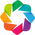

Calculating MAP estimate for plot...
MAP estimate calculated.
Using color limits for posterior: (0.0, 0.009967046859674141)
Pre-computing posterior images for HoloMap...
HoloMap created.


BokehModel(combine_events=True, render_bundle={'docs_json': {'656f776e-b2ee-4fdc-a6a8-e6cc025b2854': {'version…

In [32]:
hv.extension("bokeh")
pn.extension()

# --- Create Visualization ---
create_visualization(
    position_info_df,
    posterior_xr,
    multiunit_firing_rate_xr.to_dataframe(),
    non_local_prob_xr.to_dataframe(),
    map_estimate=None,
    sampling_frequency=250,
    width=1000,
    height=600,
    window_lim=(-0.1, 0.1),
    position_names=("x", "y"),
    speed_name="speed",
    head_dir_name="head_direction",
)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
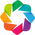

In [23]:

import holoviews as hv
import numpy as np
import pandas as pd
import panel as pn
import xarray as xr
from holoviews.streams import Pipe

hv.extension("bokeh")
pn.extension()


def create_playback_speed_dropdown(
    player: pn.widgets.Player,
    sampling_frequency: int = 250,
    width: int = 200,
):
    speed_options = {
        "1/8×": 8,
        "1/4×": 4,
        "1/2×": 2,
        "1×": 1,
        "2×": 0.5,
        "4×": 0.25,
        "8×": 0.125,
    }
    dropdown = pn.widgets.Select(
        name="Playback Speed",
        options=speed_options,
        value=1,
        width=width,
    )
    base_interval = 1000 / sampling_frequency  # ms per data‐bin at 1×

    def _update(event):
        player.interval = int(event.new * base_interval)

    dropdown.param.watch(_update, "value")
    return dropdown


def create_streamed_2D_decoding_plot(
    position_info: pd.DataFrame,
    posterior: xr.DataArray,
    map_estimate: np.ndarray | None,
    head_dir_radius: float,
    cmap: str,
    animal_color: str,
    decode_opacity: float,
    width: int,
    height: int,
    sampling_frequency: int,
    target_fps: int,
) -> tuple[pn.Column, pn.widgets.Player]:
    n_time = posterior.sizes["time"]

    # Precompute MAP & color‐limits
    if map_estimate is None:
        map_estimate = maximum_a_posteriori_estimate(posterior)
    vmin = 0.0
    vmax = float(posterior.quantile(0.995))
    if vmax <= vmin:
        vmax = float(posterior.max())
    clim = (vmin, vmax)

    # Grab grid coords & first slice
    sample = posterior.isel(time=0)
    x_coords = sample["x_position"].values
    y_coords = sample["y_position"].values
    arr0 = sample.values  # shape (ny, nx)

    # Templates
    img_tmpl = hv.Image(
        (x_coords, y_coords, arr0),
        kdims=["x_position", "y_position"],
        vdims=["probability"],
    ).opts(width=width, height=height)

    pt_tmpl = hv.Points([], ["x", "y"]).opts(
        size=10, color=animal_color, width=width, height=height
    )
    seg_tmpl = hv.Segments([], ["x0", "y0", "x1", "y1"]).opts(
        line_width=3, color=animal_color, width=width, height=height
    )
    mlp_tmpl = hv.Points([], ["x_position", "y_position"]).opts(
        size=10, color="green", width=width, height=height
    )

    # One Pipe carrying a 4‐tuple in its 'data' slot
    pipe = Pipe(
        data=(
            (x_coords, y_coords, arr0),
            [(position_info.iloc[0]["x"], position_info.iloc[0]["y"])],
            [
                (
                    position_info.iloc[0]["x"],
                    position_info.iloc[0]["y"],
                    position_info.iloc[0]["x"]
                    + head_dir_radius * np.cos(position_info.iloc[0]["head_direction"]),
                    position_info.iloc[0]["y"]
                    + head_dir_radius * np.sin(position_info.iloc[0]["head_direction"]),
                )
            ],
            [tuple(map_estimate[0])],
        )
    )

    # DynamicMap unpacks that 4‐tuple into img, pt, seg, mlp
    dmap = hv.DynamicMap(
        lambda data: (
            img_tmpl.clone(data=data[0])
            * pt_tmpl.clone(data=data[1])
            * seg_tmpl.clone(data=data[2])
            * mlp_tmpl.clone(data=data[3])
        ),
        streams=[pipe],
    )

    # Rasterize so each update is only a bitmap swap
    rasterized = rasterize(dmap, width=width, height=height).opts(
        {
            "Image": {
                "cmap": cmap,
                "clim": clim,
                "alpha": decode_opacity,
                "colorbar": True,
            }
        }
    )

    # Player at exact target_fps
    interval_ms = int(1000 / target_fps)
    player = pn.widgets.Player(
        name="Time",
        start=0,
        end=n_time - 1,
        value=0,
        step=1,
        interval=interval_ms,
        width=int(width * 0.8),
        show_loop_controls=False,
    )

    # On each tick, push new raw NumPy data into the Pipe
    def _update(event):
        i = int(event.new)
        arr = posterior.isel(time=i).values
        img_data = (x_coords, y_coords, arr)

        xi, yi = position_info.iloc[i][["x", "y"]]
        pt_data = [(xi, yi)]

        θ = position_info.iloc[i]["head_direction"]
        seg_data = [
            (
                xi,
                yi,
                xi + head_dir_radius * np.cos(θ),
                yi + head_dir_radius * np.sin(θ),
            )
        ]

        mlp_data = [tuple(map_estimate[i])]
        pipe.send(data=(img_data, pt_data, seg_data, mlp_data))

    player.param.watch(_update, "value")

    speed_ctrl = create_playback_speed_dropdown(
        player, sampling_frequency, width=int(width * 0.2)
    )

    pane = pn.Column(rasterized, pn.Row(player, speed_ctrl))
    return pane, player


def create_static_curve_with_dynamic_xlim(
    data,
    ylabel: str,
    ylim: tuple[float, float],
    player: pn.widgets.Player,
    window_lim: tuple[float, float],
    height_factor: float,
    width: int,
    height: int,
):
    # Accept pd.Series, single-col DataFrame or xr.DataArray
    if isinstance(data, pd.DataFrame):
        if data.shape[1] != 1:
            raise ValueError("DataFrame must have exactly one column")
        series = data.iloc[:, 0]
    elif isinstance(data, pd.Series):
        series = data
    elif isinstance(data, xr.DataArray):
        series = pd.Series(data.values, index=data["time"].values)
    else:
        raise TypeError("Data must be Series, single-column DataFrame, or xr.DataArray")

    t = series.index.to_numpy()
    vals = series.to_numpy()
    n = len(vals)
    if n == 0:
        return hv.Curve([]).opts(
            width=width, height=int(height / height_factor), ylim=ylim, axiswise=True
        )

    full = hv.Curve((t, vals), "Time (s)", ylabel).opts(
        color="black",
        width=width,
        height=int(height / height_factor),
        ylim=ylim,
        axiswise=True,
    )

    def view(idx):
        idx = max(0, min(idx, n - 1))
        ct = t[idx]
        start, end = ct + window_lim[0], ct + window_lim[1]
        vline = hv.VLine(ct).opts(color="red", line_dash="dashed")
        return full.opts(xlim=(start, end), ylim=ylim, framewise=True) * vline

    return hv.DynamicMap(pn.bind(view, player.param.value)).opts(framewise=True)


def create_visualization(
    position_info: pd.DataFrame,
    posterior: xr.DataArray,
    multiunit_firing_rate: pd.DataFrame,
    non_local_prob: pd.DataFrame,
    map_estimate: np.ndarray | None = None,
    sampling_frequency: int = 250,
    width: int = 1000,
    height: int = 600,
    window_lim: tuple[float, float] = (-0.1, 0.1),
    position_names: tuple[str, str] = ("x", "y"),
    speed_name: str = "speed",
    head_dir_name: str = "head_direction",
):
    # Left: 2D decoding + controls
    decode_panel, player = create_streamed_2D_decoding_plot(
        position_info,
        posterior,
        map_estimate,
        head_dir_radius=4,
        cmap="viridis",
        animal_color="magenta",
        decode_opacity=1.0,
        width=width // 2,
        height=height,
        sampling_frequency=sampling_frequency,
        target_fps=30,
    )

    # Right: three scrolling plots
    mua = multiunit_firing_rate.to_numpy().squeeze()
    mua_ylim = (0, mua.max() * 1.1 if mua.size else 1)
    speed = position_info[speed_name].to_numpy()
    speed_ylim = (0, speed.max() * 1.1 if speed.size else 10)

    common = {
        "player": player,
        "window_lim": window_lim,
        "height_factor": 3.1,
        "width": int(width * 0.4),
        "height": height,
    }

    mua_plot = create_static_curve_with_dynamic_xlim(
        multiunit_firing_rate, "Rate (spikes/s)", mua_ylim, **common
    )
    speed_plot = create_static_curve_with_dynamic_xlim(
        position_info[[speed_name]], "Speed (cm/s)", speed_ylim, **common
    )
    nl_plot = create_static_curve_with_dynamic_xlim(
        non_local_prob, "Non-Local prob", (0, 1.05), **common
    )

    right_col = pn.Column(mua_plot, speed_plot, nl_plot)
    return pn.Row(decode_panel, right_col)

In [24]:
layout = create_visualization(
    position_info_df,
    posterior_xr,
    multiunit_firing_rate_xr.to_dataframe(),
    non_local_prob_xr.to_dataframe(),
    map_estimate=None,
    sampling_frequency=250,
    width=1000,
    height=600,
    window_lim=(-0.1, 0.1),
    position_names=("x", "y"),
    speed_name="speed",
    head_dir_name="head_direction",
)
layout.servable()


BokehModel(combine_events=True, render_bundle={'docs_json': {'c25369b6-a00e-4b96-8999-a42553747ec6': {'version…